- Having a family
- Having a spouse
- Ship deck
- Class
- Age
- Gender
- Expensive tickets vs cheap tickets

In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import seaborn as sns

pd.options.display.max_colwidth = 0
pd.options.display.max_columns = 0
plt.rcParams['figure.figsize'] = 18, 6

In [68]:
train_types = {
    'Age': np.float32,
    'Cabin': str,
    'Embarked': str,
    'Fare': np.float32,
    'Name': str,
    'Parch': np.int8,
    'Pclass': np.int8,
    'Sex': str,
    'SibSp': np.int8,
    'Survived': np.int8,
    'Ticket': str
}

train = pd.read_csv('data/train.csv', index_col='PassengerId', dtype=train_types)
test = pd.read_csv('data/test.csv', index_col='PassengerId', dtype=train_types)
full = pd.concat([train, test])
full.columns = full.columns.str.lower()
full.index.rename('pid', inplace=True)
full.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,survived,ticket
pid,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.283302,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.099998,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


In [69]:
full.isnull().sum()

age         263 
cabin       1014
embarked    2   
fare        1   
name        0   
parch       0   
pclass      0   
sex         0   
sibsp       0   
survived    418 
ticket      0   
dtype: int64

In [159]:
full[['surname','title']] = full.name.str.extract('(\w+), (.*?)\..*', expand=True)
full['title'] = full['title'].replace('Ms', 'Miss')
to_replace = list(set(full['title'].tolist()).difference(['Mr', 'Miss', 'Mrs', 'Master']))
full['title'] = full['title'].replace(to_replace, 'Other')

full['famsize'] = full['sibsp'] + full['parch'] + 1
full['deck'] = full['cabin'].str.extract('([A-Z]).*',expand=True)
full['deck'].fillna('X', inplace=True)
full.loc[:, 'adult'] = 1
full.loc[full['age'] < 18, 'adult'] = 0

full['embarked'].fillna('S', inplace=True)
full['fare'].fillna(8.05, inplace=True)
full['age'].fillna(full['age'].median(), inplace=True)

full['gender'] = full['sex'].map({'male':1, 'female':0})
full['npass'] = full.groupby('ticket')['ticket'].transform('count')
full['fare_adj'] = full['fare'] / full['npass']
full.head()

,age,cabin,embarked,fare,name,parch,pclass,sex,sibsp,survived,ticket,surname,title,deck,adult,gender,npass,fare_adj,famsize
pid,,,,,,,,,,,,,,,,,,,
1,22.0,NaN,S,7.250000,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171,Braund,Mr,X,1,1,1,7.250000,2
2,38.0,C85,C,71.283302,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",0,1,female,1,1.0,PC 17599,Cumings,Mrs,C,1,0,2,35.641651,2
3,26.0,NaN,S,7.925000,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282,Heikkinen,Miss,X,1,0,1,7.925000,1
4,35.0,C123,S,53.099998,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803,Futrelle,Mrs,C,1,0,2,26.549999,2
5,35.0,NaN,S,8.050000,"Allen, Mr. William Henry",0,3,male,0,0.0,373450,Allen,Mr,X,1,1,1,8.050000,1


In [160]:
full.isnull().sum()

age         0   
cabin       1014
embarked    0   
fare        0   
name        0   
parch       0   
pclass      0   
sex         0   
sibsp       0   
survived    418 
ticket      0   
surname     0   
title       0   
deck        0   
adult       0   
gender      0   
npass       0   
fare_adj    0   
famsize     0   
dtype: int64

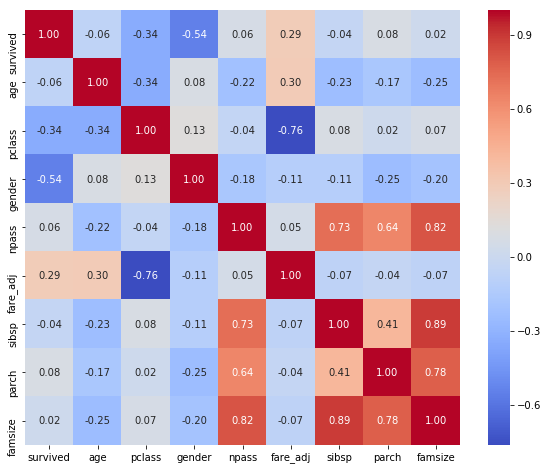

In [162]:
f, ax = plt.subplots(figsize=[10,8])
train = full[~full['survived'].isnull()]
sns.heatmap(
    train[['survived', 'age', 'pclass', 'gender', 'npass', 'fare_adj', 'sibsp', 'parch', 'famsize']].corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    square=True
)
plt.show()

In [169]:
encoded = full.drop(['fare', 'cabin', 'name', 'surname', 'ticket', 'sex', 'sibsp', 'parch'], axis=1)
encoded = pd.get_dummies(encoded)

train = encoded[~encoded['survived'].isnull()]
train.head()

,age,pclass,survived,adult,gender,npass,fare_adj,famsize,embarked_C,embarked_Q,embarked_S,title_Master,title_Miss,title_Mr,title_Mrs,title_Other,deck_A,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_X
pid,,,,,,,,,,,,,,,,,,,,,,,,,
1,22.0,3,0.0,1,1,1,7.250000,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2,38.0,1,1.0,1,0,2,35.641651,2,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
3,26.0,3,1.0,1,0,1,7.925000,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,35.0,1,1.0,1,0,2,26.549999,2,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0
5,35.0,3,0.0,1,1,1,8.050000,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [200]:
y = train['survived']
x = train.drop('survived', axis=1)

seed = 245
clf = RandomForestClassifier(n_estimators=50, random_state=seed)
clf.fit(x, y)

scores = cross_val_score(clf, x, y, cv=5)
print('Score: {:.2f} +/- {:.2f}'.format(np.mean(scores), np.std(scores)))

Score: 0.81 +/- 0.03


In [194]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth' : [6, 8, 10],
    'n_estimators': [50, 10],
    'max_features': ['sqrt'],
    'min_samples_split': [8, 10, 12],
    'min_samples_leaf': [1, 3, 10],
}
clf = RandomForestClassifier(n_jobs=2, random_state=seed)

grid_search = GridSearchCV(
    clf,
    scoring='accuracy',
    param_grid=parameter_grid,
    cv=3,
    n_jobs=2,
    verbose=1
)

grid_search.fit(x, y)
clf = grid_search.best_estimator_
parameters = grid_search.best_params_

print('Best score: {:.2f}'.format(grid_search.best_score_))
print('Best estimator: {}'.format(grid_search.best_estimator_))

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.9s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   33.5s


Best score: 0.8417508417508418
Best estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=8, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
            oob_score=False, random_state=245, verbose=0, warm_start=False)


[Parallel(n_jobs=2)]: Done 324 out of 324 | elapsed:   55.5s finished


In [196]:
['{}: {:.2f}'.format(name, i) for name, i in zip(x.columns, clf.feature_importances_)]

['age: 0.08',
 'pclass: 0.07',
 'adult: 0.01',
 'gender: 0.29',
 'npass: 0.06',
 'fare_adj: 0.14',
 'famsize: 0.06',
 'embarked_C: 0.01',
 'embarked_Q: 0.00',
 'embarked_S: 0.01',
 'title_Master: 0.01',
 'title_Miss: 0.03',
 'title_Mr: 0.11',
 'title_Mrs: 0.05',
 'title_Other: 0.01',
 'deck_A: 0.00',
 'deck_B: 0.00',
 'deck_C: 0.00',
 'deck_D: 0.01',
 'deck_E: 0.00',
 'deck_F: 0.01',
 'deck_G: 0.00',
 'deck_T: 0.00',
 'deck_X: 0.05']

In [198]:
result = pd.DataFrame()
test = encoded[encoded['survived'].isnull()]
test = test.drop('survived', axis=1)
result = pd.DataFrame({'PassengerId': test.index.tolist()})
result['Survived'] = clf.predict(test).astype(int)
result.to_csv('submissions/submission.csv', index=False)